# Exploring different numerical schemes

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
import pandas as pd

a  = 1.0 # advection speed
nx = 200 # number of grid points
T  = 1.0 # final time
x  = np.linspace(0,1,nx,endpoint=False)

def exact(a,T,x):
    return np.exp(-(((x - a*T)%1 - 0.25)/0.05)**2)

    
t_ex = np.linspace(0,T,500)
u_ex = exact(a,T,t_ex)
CFLs = [0.9, 1.0, 1.1]

# dict of schemes
error_table = {}


### Backward Euler

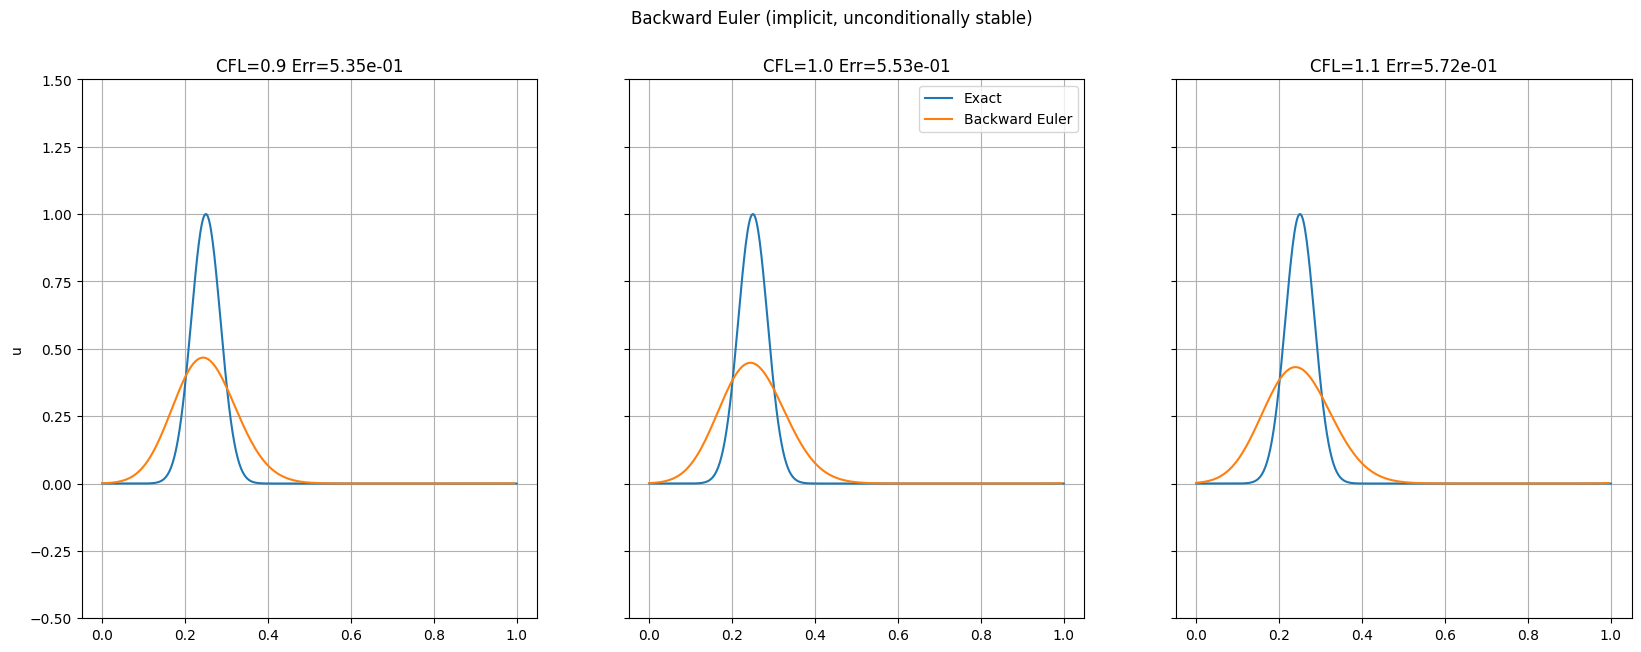

In [228]:
def backward_euler(a, x, cfl, T):
    nx = x.size
    dx = 1/nx
    dt = cfl*dx/abs(a)
    nt = int(T/dt)

    ν = a*dt/(2*dx)
    N = nx
    A = diags(
        [
            -ν*np.ones(N),
             np.ones(N),
             +ν*np.ones(N)
        ],
        offsets=[-1, 0, +1],
        shape=(N, N),
        format='lil'
    )
    A[0, -1] = -ν
    A[-1, 0] = +ν

    A = A.tocsc()
    u = np.exp(-((x-0.25)/0.05)**2)

    for _ in range(nt):
        u = np.linalg.solve(A.toarray(), u)

    return u

error_table['Euler'] = {}
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
for ax, cfl in zip(axes, CFLs):
    u_num = backward_euler(a, x, cfl, T)
    err = np.max(np.abs(u_num - exact(a, T, x)))
    error_table['Euler'][cfl] = f'{err:.2e}'

    ax.plot(t_ex, u_ex, '-', label='Exact')
    ax.plot(x,    u_num, '-', label='Backward Euler')
    ax.set_title(f'CFL={cfl:.1f} Err={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right')
plt.ylim(-0.5, 1.5)
plt.suptitle('Backward Euler (implicit, unconditionally stable)')
plt.show()


### One sided (Left) / Downwind

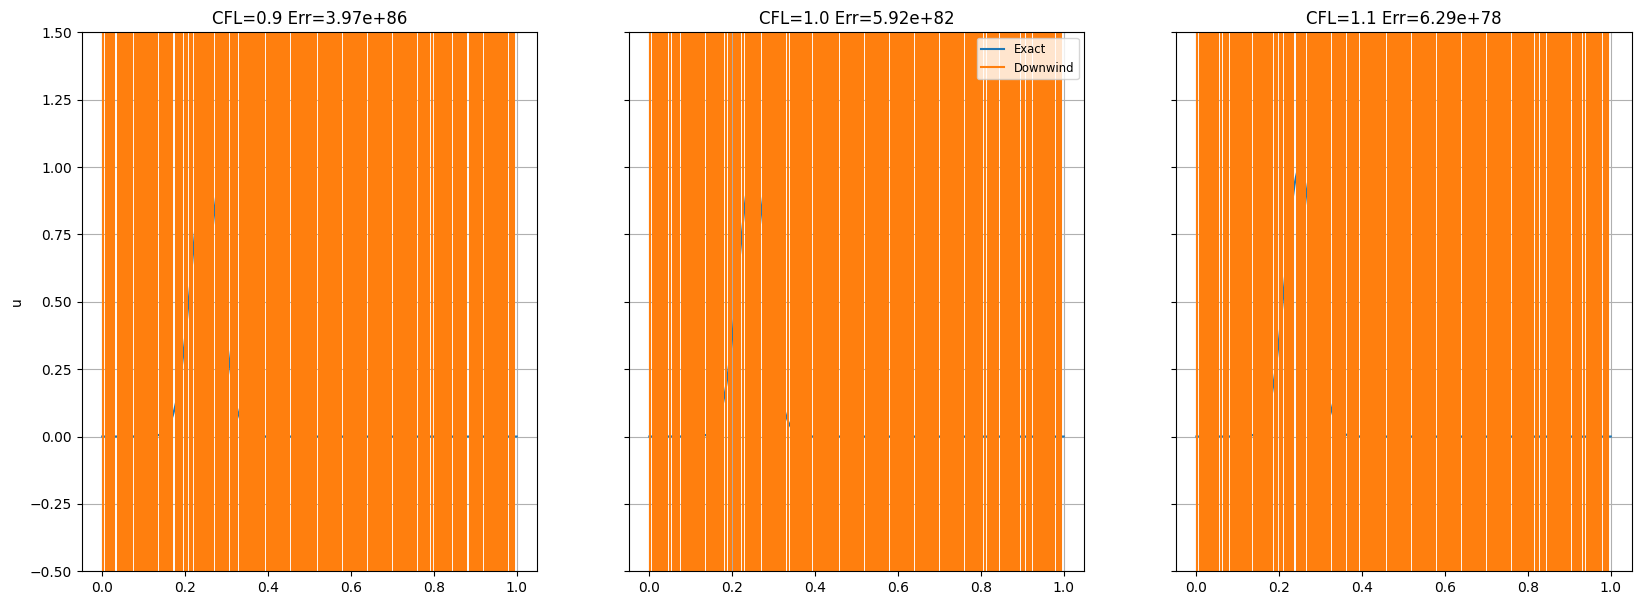

In [229]:
def downwind(a,nx,cfl,T):
    dx=1/nx
    dt=cfl*dx/abs(a)
    nt=int(T/dt)
    u = np.exp(-((x-0.25)/0.05)**2)
    for _ in range(nt):
        un = u.copy(); ν=a*dt/dx
        if a>0:
            u = un - ν*(np.roll(un,-1) - un)
        else:
            u = un - ν*(un - np.roll(un,1))
    return u

error_table['Downwind'] = {}
fig,axes = plt.subplots(1,3,figsize=(20,7),sharey=True)
for ax,cfl in zip(axes,CFLs):
    u=downwind(a,nx,cfl,T)
    err=np.max(np.abs(u-exact(a,T,x)))
    ax.plot(t_ex,u_ex,'-',label='Exact')
    ax.plot(x,u,'-',label='Downwind')
    ax.set_title(f'CFL={cfl:.1f} Err={err:.2e}')
    ax.grid()
    error_table['Downwind'][cfl] = f'{err:.2e}'
    
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.ylim(-0.5, 1.5)
plt.show()


### One sided (Right) / Upwind

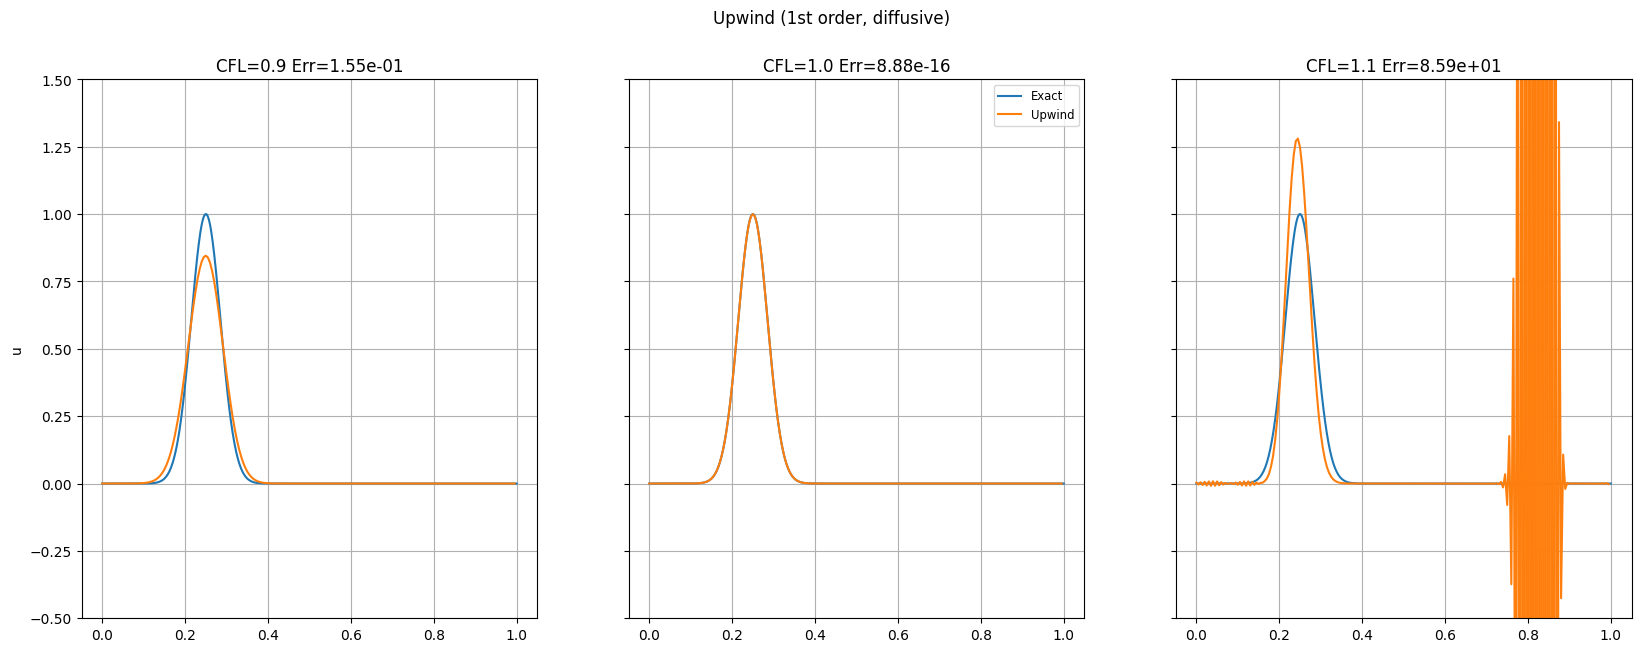

In [230]:
def upwind(a,nx,cfl,T):
    dx=1/nx
    dt=cfl*dx/abs(a)
    nt=int(T/dt)

    u = np.exp(-((x-0.25)/0.05)**2)

    for _ in range(nt):
        un = u.copy(); ν=a*dt/dx
        if a>0:
            u = un - ν*(un - np.roll(un,1))
        else:
            u = un - ν*(np.roll(un,-1) - un)
    return u

error_table['Upwind'] = {}
fig,axes = plt.subplots(1,3,figsize=(20,7),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=upwind(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    error_table['Upwind'][cfl] = f'{err:.2e}'
    ax.plot(t_ex,u_ex,'-',label='Exact')
    ax.plot(x,u,'-',label='Upwind')
    ax.set_title(f'CFL={cfl:.1f} Err={err:.2e}')
    ax.grid()
    
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.ylim(-0.5, 1.5)
plt.suptitle('Upwind (1st order, diffusive)')
plt.show()


### Lax-Friedrichs

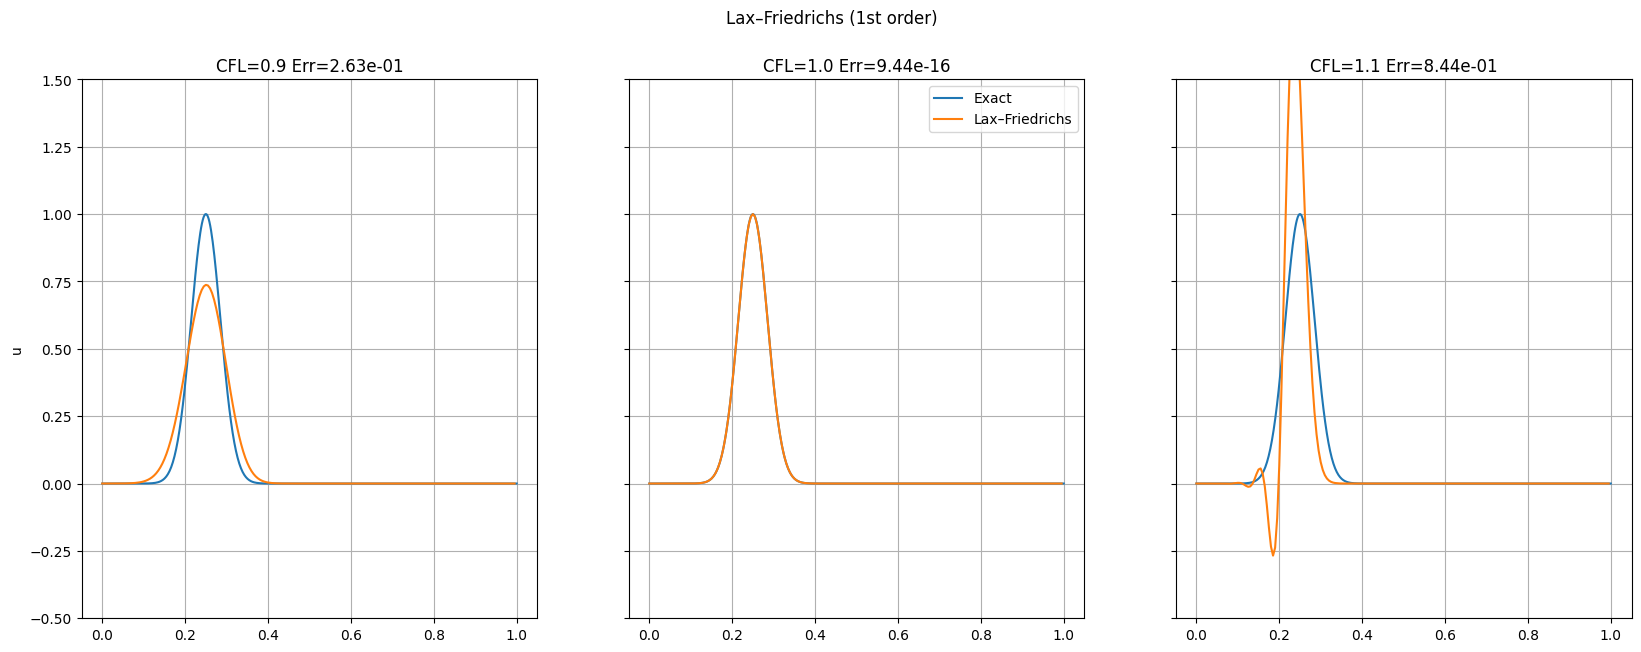

In [231]:
def lax_friedrichs(a, nx, cfl, T):
    dx = 1/nx
    dt = cfl*dx/abs(a)
    nt = int(T/dt)
    ν  = a*dt/dx

    u = np.exp(-((x - 0.25)/0.05)**2)

    for _ in range(nt):
        ul, ur = np.roll(u,1), np.roll(u,-1)
        u = 0.5*(ul + ur) - 0.5*ν*(ur - ul)

    return u

error_table['Lax-Friedrichs'] = {}
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
for ax, cfl in zip(axes, CFLs):
    u_num = lax_friedrichs(a, nx, cfl, T)
    err   = np.max(np.abs(u_num - exact(a, T, x)))
    error_table['Lax-Friedrichs'][cfl] = f'{err:.2e}'

    ax.plot(t_ex, u_ex, '-', label='Exact')
    ax.plot(x, u_num, '-', label='Lax–Friedrichs')
    ax.set_title(f'CFL={cfl:.1f} Err={err:.2e}')
    ax.grid()

axes[0].set_ylabel('u')
axes[1].legend(loc='upper right')
plt.ylim(-0.5, 1.5)
plt.suptitle('Lax–Friedrichs (1st order)')
plt.show()


### Leapfrog

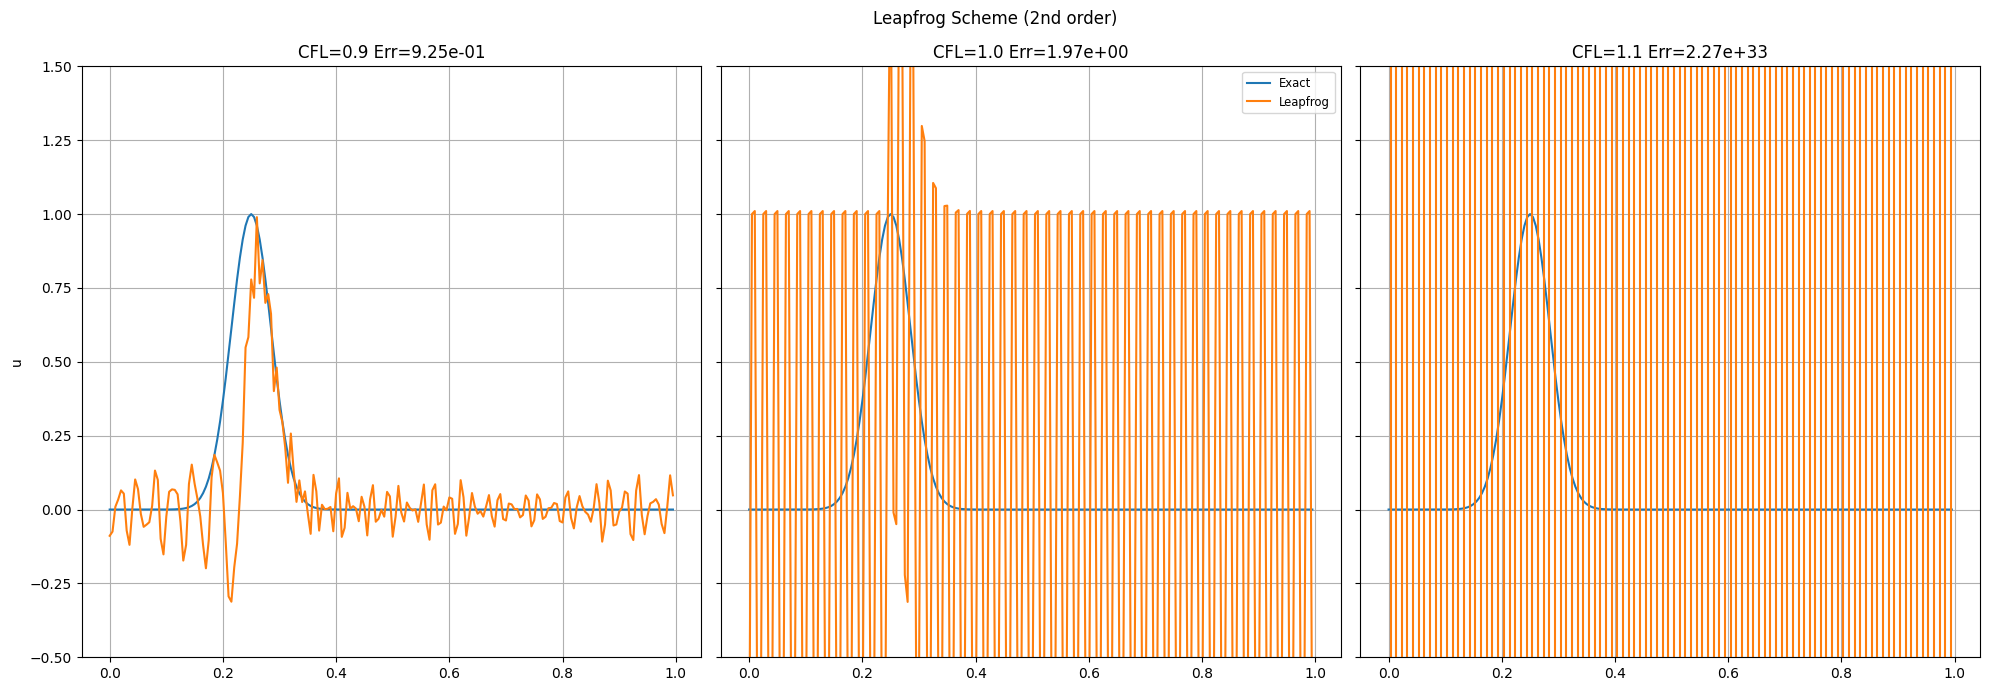

In [232]:
def leapfrog(a, nx, cfl, T):
    dx = 1.0/nx
    dt = cfl*dx/abs(a)
    nt = int(np.ceil(T/dt))
    dt = T/nt
    ν  = a*dt/dx

    u0   = np.exp(-(((x - 0.25)%1)/0.05)**2)

    ul, ur = np.roll(u0, 1), np.roll(u0, -1)
    u_nm1  = u0.copy()
    u_n    = u0 - 0.5*ν*(ur - ul)

    for _ in range(1, nt):
        ul, ur = np.roll(u_n, 1), np.roll(u_n, -1)
        u_np1  = u_nm1 - ν*(ur - ul)
        u_nm1, u_n = u_n, u_np1

    return u_n

u_ex = exact(a, T, x)

error_table['Leapfrog'] = {}
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
for ax, cfl in zip(axes, CFLs):
    u_num = leapfrog(a, nx, cfl, T)
    err   = np.max(np.abs(u_num - u_ex))
    error_table['Leapfrog'][cfl] = f'{err:.2e}'

    ax.plot(x, u_ex, '-', label='Exact')
    ax.plot(x, u_num, '-', label='Leapfrog')
    ax.set_title(f'CFL={cfl:.1f} Err={err:.2e}')
    ax.grid()

axes[0].set_ylabel('u')
axes[1].legend(loc='upper right', fontsize='small')
plt.ylim(-0.5, 1.5)
plt.suptitle('Leapfrog Scheme (2nd order)')
plt.tight_layout()
plt.show()

### Lax-Wendroff

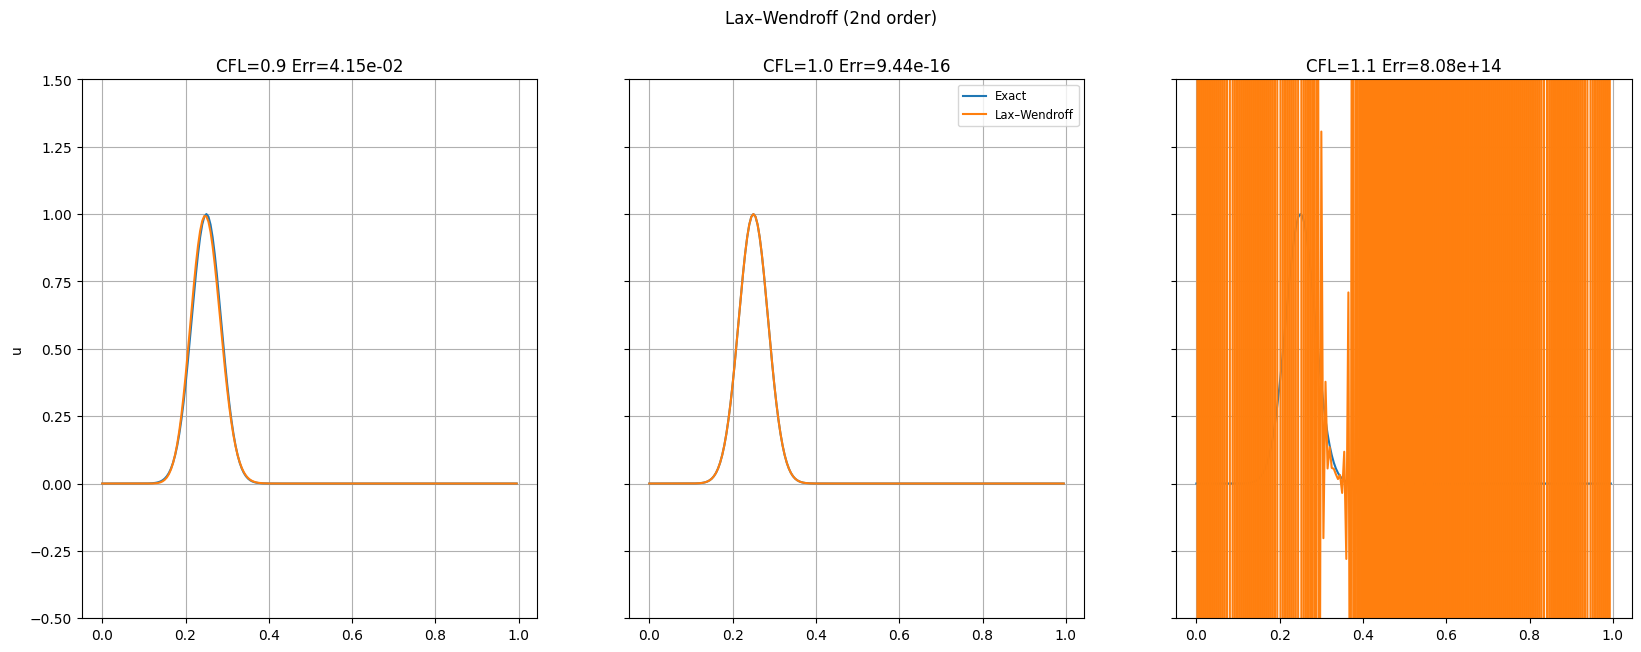

In [233]:
def lax_wendroff(a, nx, cfl, T):
    dx = 1/nx
    dt = cfl*dx/abs(a)
    nt = int(T/dt)
    
    u = np.exp(-((x-0.25)/0.05)**2)
    
    ν = a*dt/dx
    
    for _ in range(nt):
        ul, ur = np.roll(u, 1), np.roll(u, -1)
        u = u - 0.5*ν*(ur-ul) + 0.5*ν*ν*(ur - 2*u + ul)
    
    return u

error_table['Lax-Wendroff'] = {}
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
for ax, cfl in zip(axes, CFLs):
    u = lax_wendroff(a, nx, cfl, T)
    err = np.max(np.abs(u - u_ex))
    error_table['Lax-Wendroff'][cfl] = f'{err:.2e}'
    
    ax.plot(x, u_ex, '-', label='Exact')
    ax.plot(x, u, '-', label='Lax–Wendroff')
    
    ax.set_title(f'CFL={cfl:.1f} Err={err:.2e}')
    ax.grid()

axes[0].set_ylabel('u')
axes[1].legend(loc='upper right', fontsize='small')
plt.ylim(-0.5, 1.5)
plt.suptitle('Lax–Wendroff (2nd order)')
plt.show()

### Beam-Warming

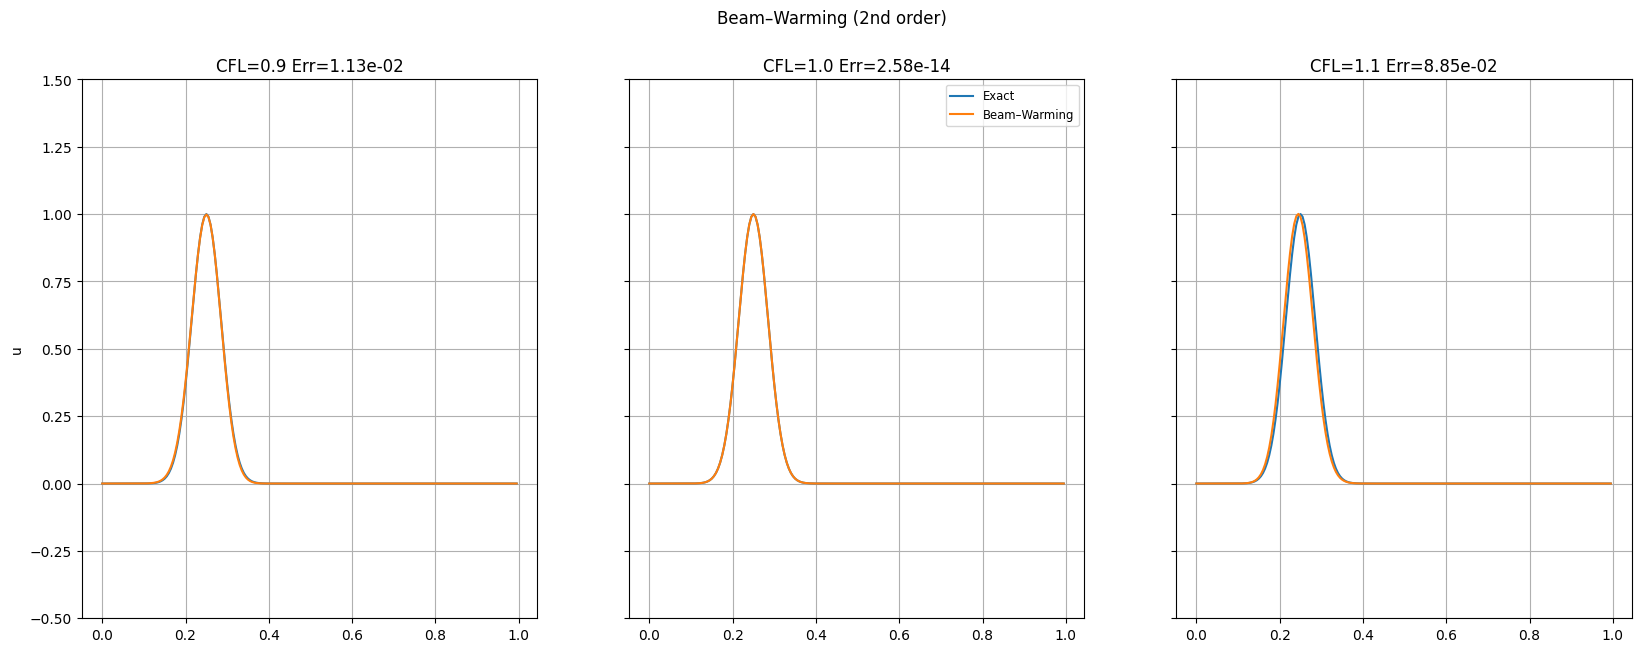

In [234]:
def beam_warming(a,nx,cfl,T):
    dx=1/nx
    dt=cfl*dx/abs(a) 
    nt=int(T/dt)
    u_prev = np.exp(-((x-0.25)/0.05)**2)

    ν = a*dt/dx
    u = u_prev - ν*(u_prev - np.roll(u_prev,1))
    for _ in range(1,nt):
        ul1, ul2, ul3 = u, np.roll(u,1), np.roll(u,2)
        u_new = (u 
                 - 0.5*ν*(3*u - 4*ul2 + ul3)
                 + 0.5*ν*ν*(u - 2*ul2 + ul3))
        u_prev, u = u, u_new
    return u

error_table['Beam-Warming'] = {}
fig,axes = plt.subplots(1,3,figsize=(20,7),sharey=True)
for ax,cfl in zip(axes,CFLs):
    u=beam_warming(a,nx,cfl,T)
    err=np.max(np.abs(u-exact(a,T,x)))
    error_table['Beam-Warming'][cfl] = f'{err:.2e}'
    ax.plot(x,u_ex,'-',label='Exact')
    ax.plot(x,u,'-',label='Beam–Warming')
    ax.set_title(f'CFL={cfl:.1f} Err={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.ylim(-0.5, 1.5)
plt.suptitle('Beam–Warming (2nd order)')
plt.show()


## Error table

In [235]:
df_error = pd.DataFrame(error_table)
df_error = df_error.T
df_error

,0.9,1.0,1.1
Euler,5.35e-01,5.53e-01,5.72e-01
Downwind,3.97e+86,5.92e+82,6.29e+78
Upwind,1.55e-01,8.88e-16,8.59e+01
Lax-Friedrichs,2.63e-01,9.44e-16,8.44e-01
Leapfrog,9.25e-01,1.97e+00,2.27e+33
Lax-Wendroff,4.15e-02,9.44e-16,8.08e+14
Beam-Warming,1.13e-02,2.58e-14,8.85e-02
